In [1]:
# import standard numerical modules
import numpy as np
import math
import tensorflow as tf

import DCTR


2024-04-09 10:16:00.686114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-09 10:16:00.686235: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_dir = './Data/'


In [3]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair; every event has order: 
# tt-pair, top, anti-top
# every particle has arguments: 
# [pt, y, phi, mass, eta, E, PID, w, theta]
# [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

# POWHEG hvq
# plotting data; different from training data
X0_plt = []
X0_plt = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_converted_lhe.npz', i=3)[:9553938] # 9553938 num of MiNNLO samples
print('POWHEG hvq all particles X0_plt.shape: '+str(X0_plt.shape))

X0_test = []
X0_test = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_normed_converted_lhe.npz', i=3)[:9553938]
print('POWHEG hvq all particles X0_test.shape: '+str(X0_test.shape))



POWHEG hvq all particles X0_plt.shape: (9553938, 3, 9)
POWHEG hvq all particles X0_test.shape: (9553938, 3, 9)


In [4]:
# MiNNLO
# plotting data
X1_plt = []
X1_plt = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_13TeV_NLO/converted_lhe.npz', i=3)
print('MiNNLO all particles X1_plt.shape: '+str(X1_plt.shape))


MiNNLO all particles X1_plt.shape: (9553938, 3, 9)


In [5]:
# get normalized event generator weights

X0_plt_wgt = X0_plt[:, 0, 7].copy()
X0_plt_wgt /= np.mean(X0_plt_wgt) 

X1_plt_wgt = X1_plt[:, 0, 7].copy()
X1_plt_wgt /= np.mean(X1_plt_wgt)


In [6]:
# delete energy
X0_test = np.delete(X0_test, 5, -1)

# delete eta
X0_test = np.delete(X0_test, 4, -1)


In [7]:
model = './best_model.tf'

''' # save weights to .h5 file
dctr = tf.keras.models.load_model(model)
dctr.save('best_model_weights.h5')
'''

# calculate rwgt
with tf.device('CPU'):
    rwgt = DCTR.get_rwgt([model], X0_test) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook


2024-04-09 10:23:37.558507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-09 10:23:37.560289: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-09 10:23:37.562021: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (finn-ThinkPad-T540p): /proc/driver/nvidia/version does not exist
2024-04-09 10:23:37.648547: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 10:23:44.778317: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5732362

In [8]:
# setup args for plotting
args = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
        (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
        (X0_plt, rwgt[0], 'dctr reweighted')]


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


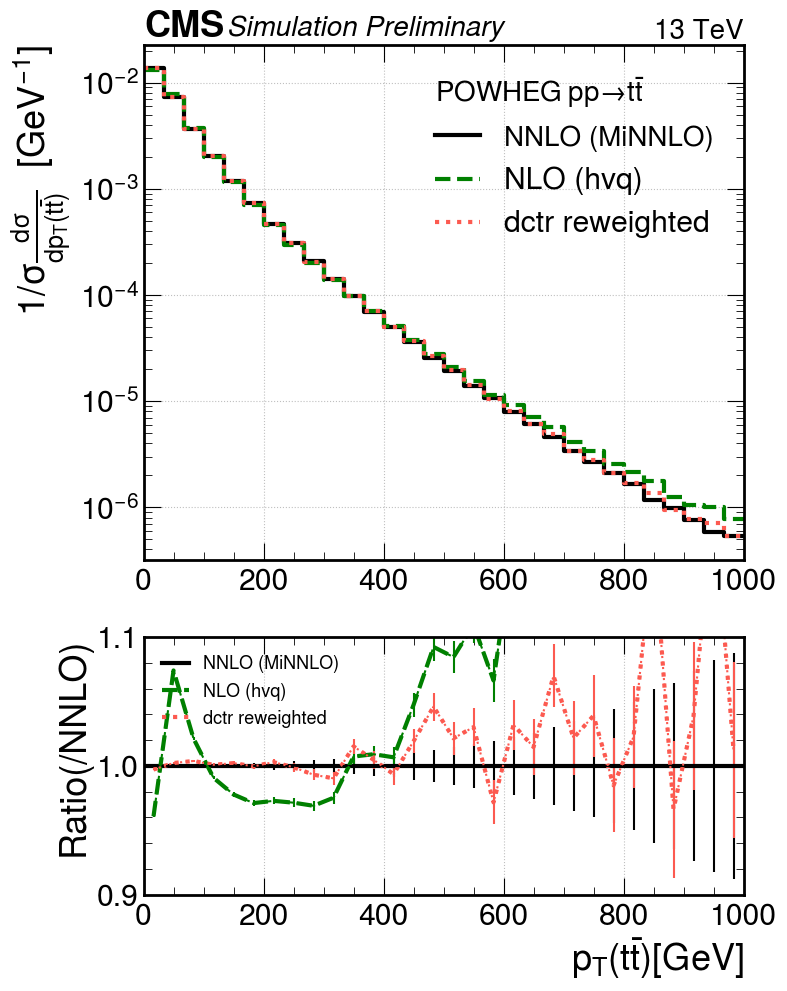

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


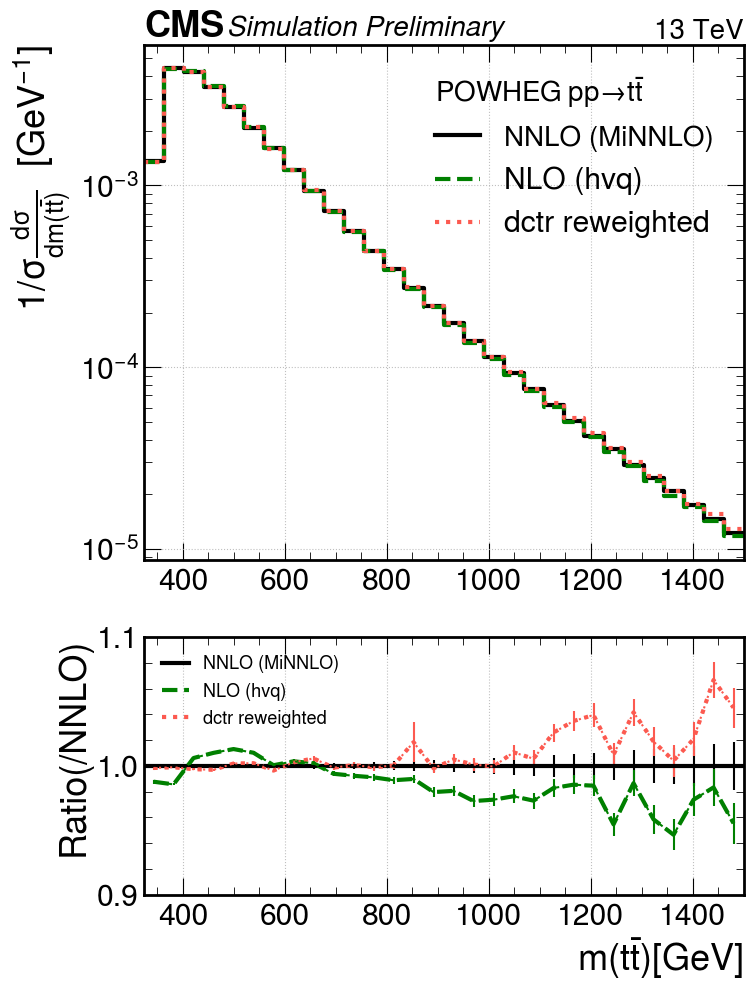

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


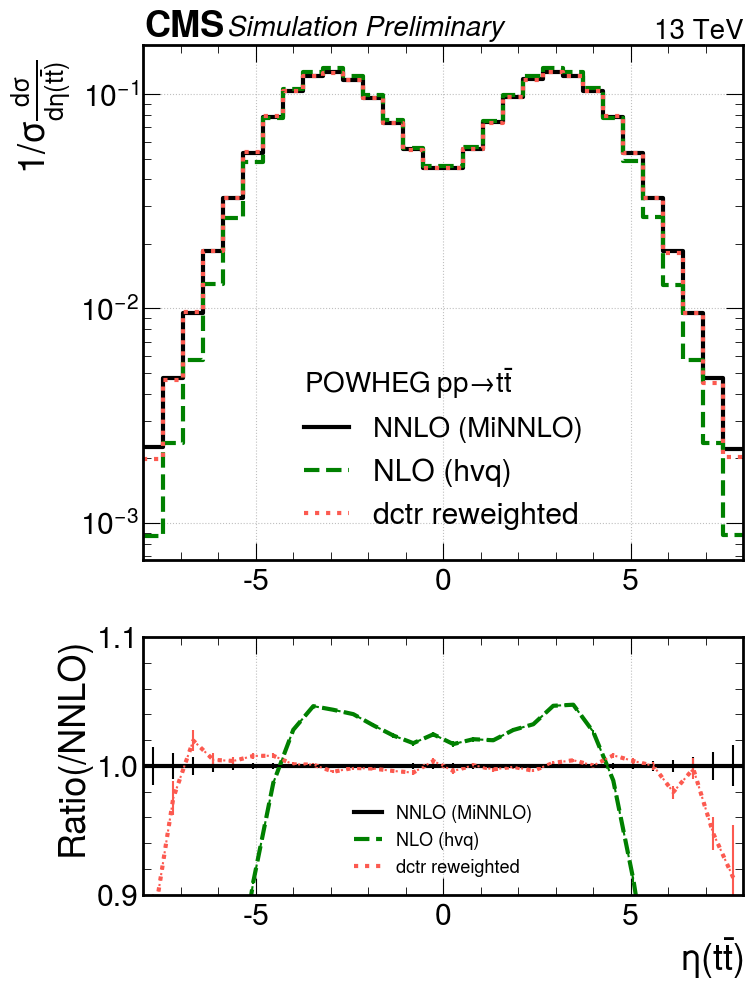

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


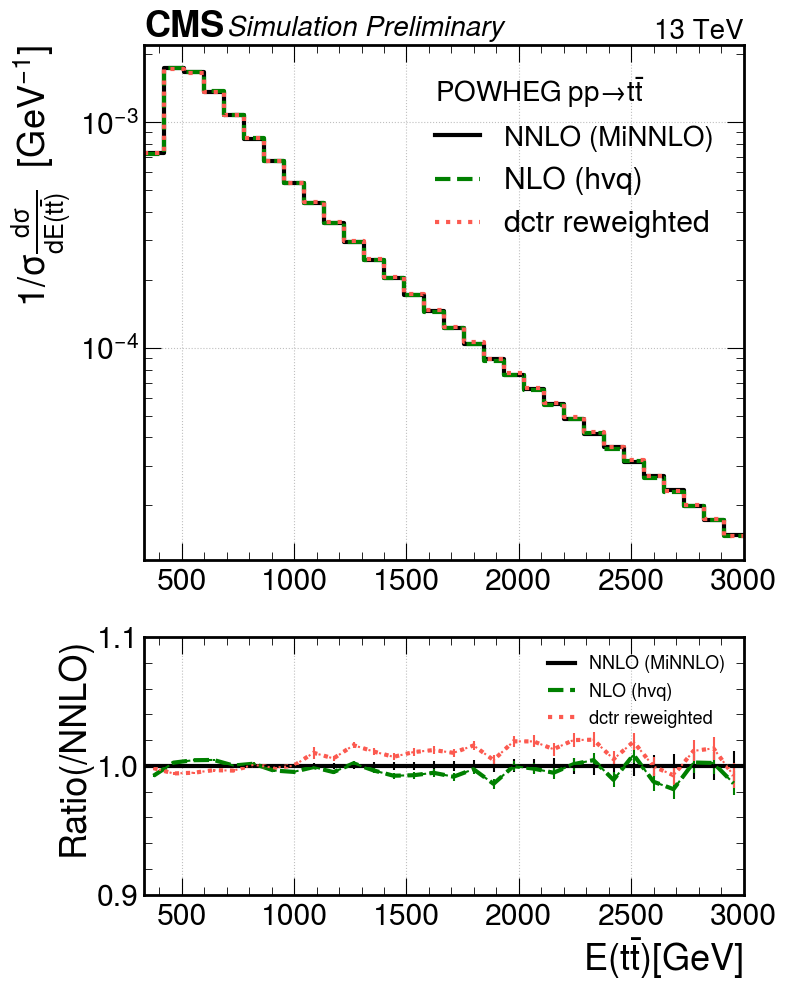

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


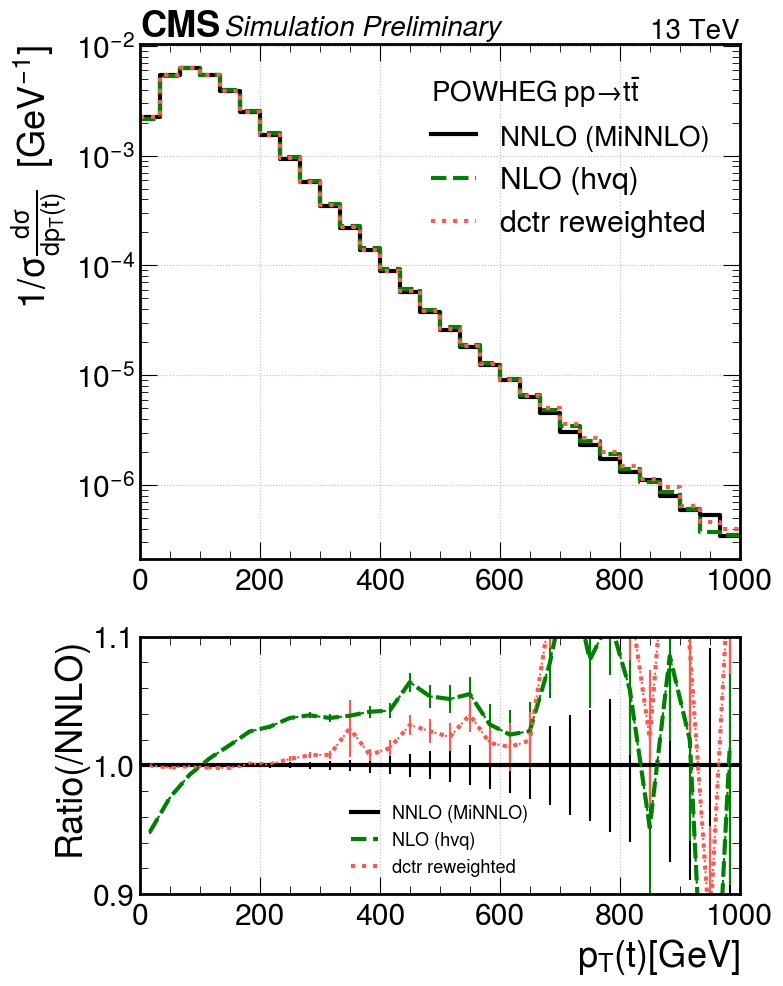

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


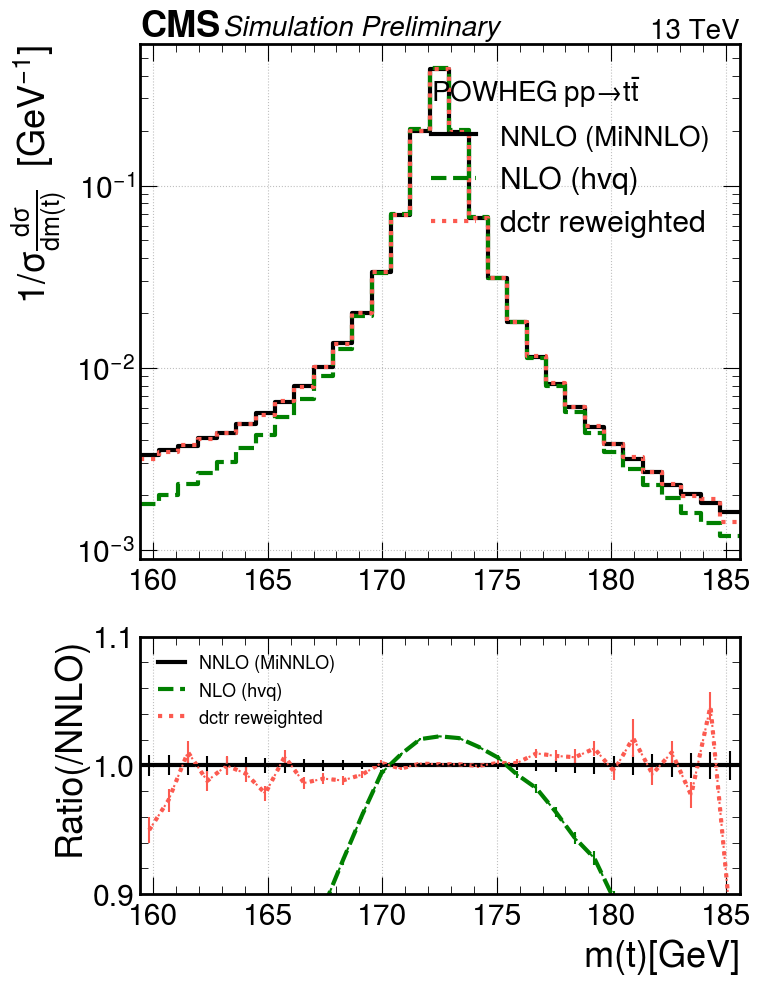

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


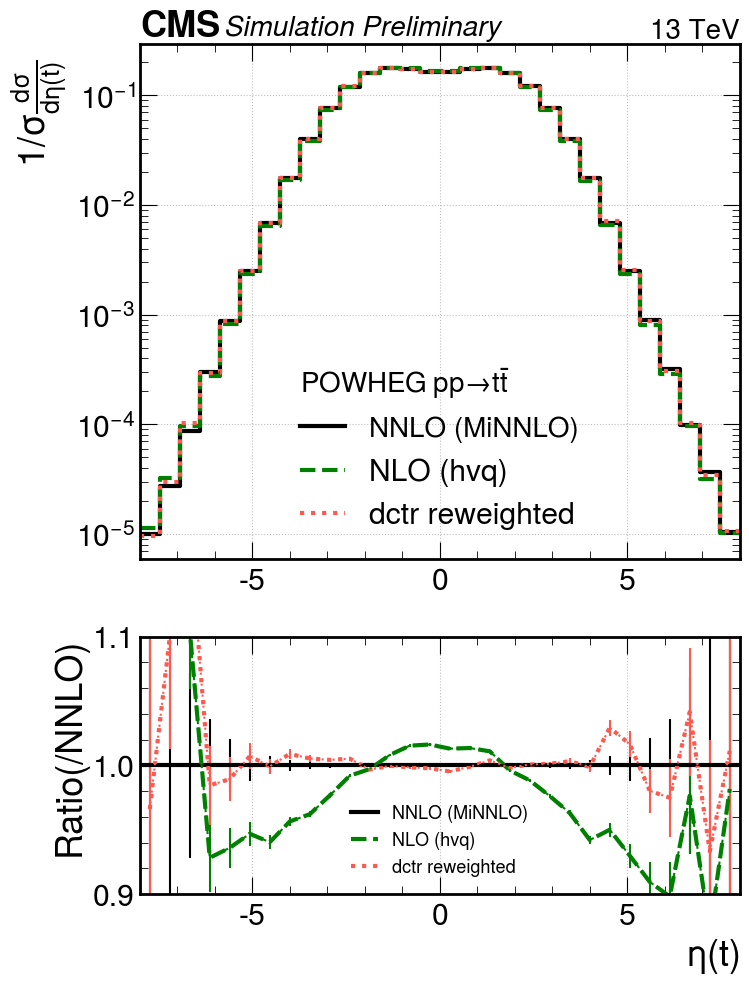

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


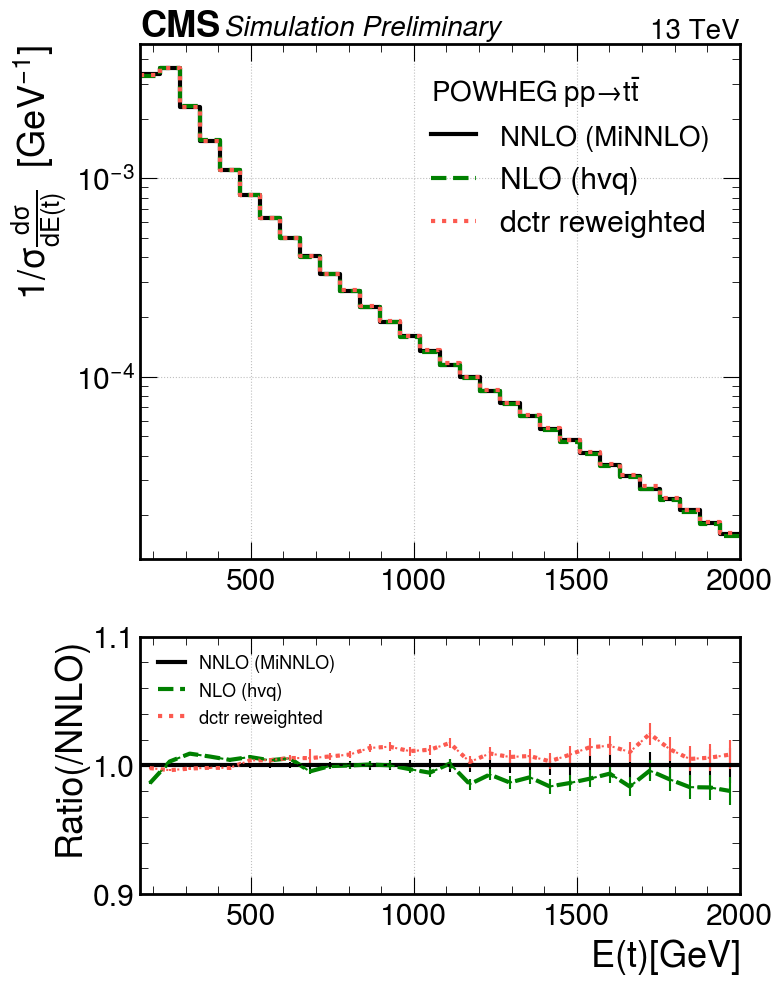

In [18]:
# plotting everything in CMS style with linear binning
''' plot_ratio_cms arguments
args, arg_index = 0, part_index = 0, title = None, x_label = None, y_label = None, bins = None, start = None, stop = None, div = 35,
ratio_ylim=[0.9,1.1], pythia_text = pythia_text, figsize=(8,10), y_scale=None, hep_text = 'Simulation Preliminary',
center_mass_energy = '13 TeV', part_label=None, arg_label=None, unit=None, inv_unit=None):

'''

arg_indices = [0, 3, 4, 5]
part_indices = [0, 1]

# plot with proper ranges set for each observable
for part_index in part_indices:
    for arg_index in arg_indices:
        div = 31
        if arg_index == 1:  # rapidity
            start = None
            stop = None
        elif arg_index == 3:  # mass
            if part_index == 0:  # tt-pair
                start = None
                stop = 1500
            else:
                start = None
                stop = None
                div = 32
        elif arg_index == 4:  # pseudorapidity
            start = -8
            stop = 8
        elif arg_index == 5: # energy
            if part_index == 0:  # tt-pair
                start = None
                stop = 3000
            else:
                start = None
                stop = 2000
        else:  # pt
            start = 0
            stop = 1000
        
        DCTR.plot_ratio_cms(args, arg_index=arg_index, part_index=part_index, start=start, stop=stop, div=div, y_scale='log', pythia_text=r'$POWHEG \; pp \to  t\bar{t}$')



'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


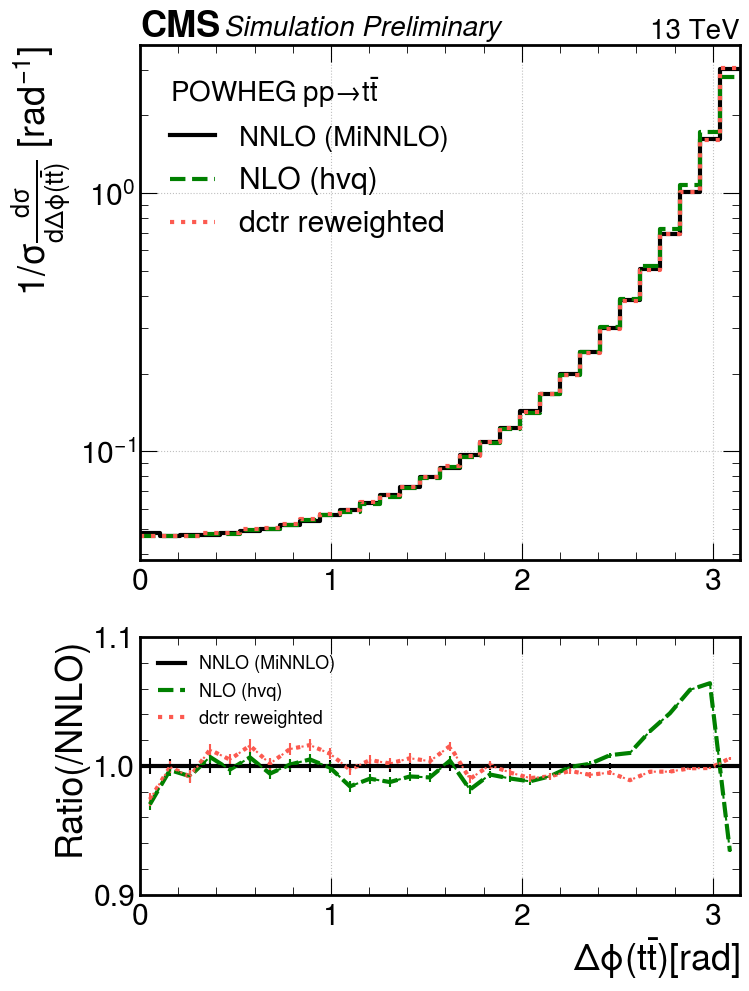

In [11]:
# delta phi
X0_delta_phi = DCTR.delta_phi(X0_plt)
X1_delta_phi = DCTR.delta_phi(X1_plt)

args_delta_phi = [(X1_delta_phi, X1_plt_wgt, 'NNLO (MiNNLO)'), 
                  (X0_delta_phi, X0_plt_wgt, 'NLO (hvq)'),
                  (X0_delta_phi, rwgt[0], 'dctr reweighted')]


DCTR.plot_ratio_cms(args_delta_phi, start = 0, stop = math.pi, div=31, part_label=r't \bar{t}', arg_label=r'\Delta \phi', unit='[rad]', inv_unit='[rad$^{-1}$]', y_scale='log')


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


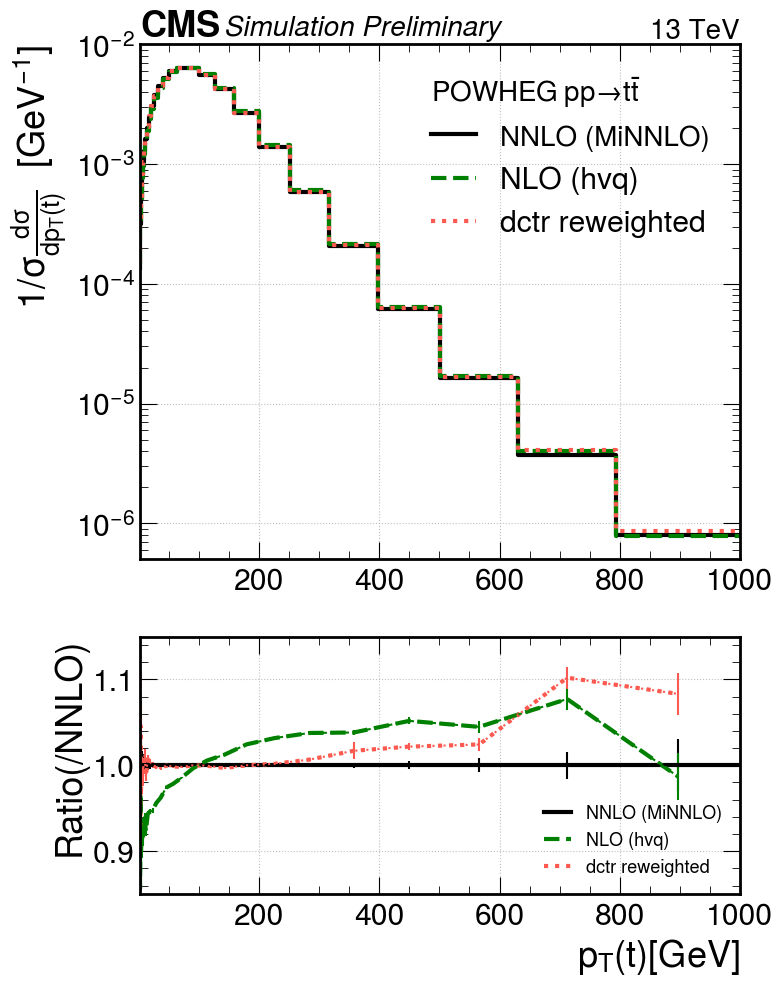

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


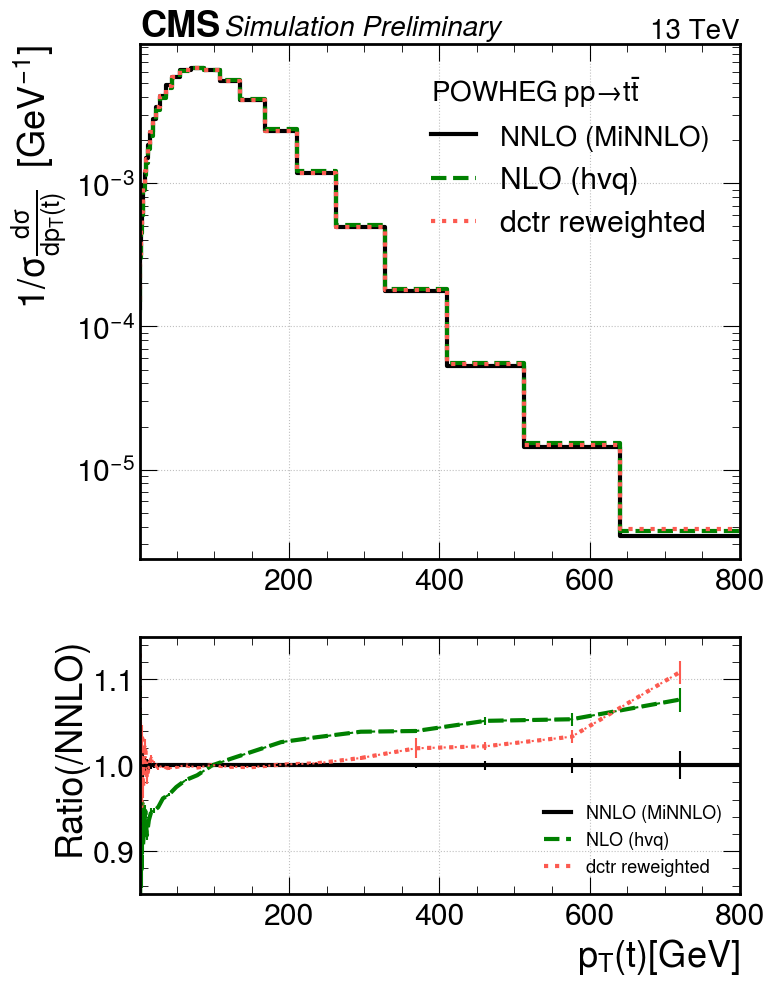

In [44]:
# p_T (tt) log binning
log_bins = np.logspace(np.log10(1), np.log10(1000), 31)
DCTR.plot_ratio_cms(args, arg_index=0, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.85, 1.15])

# p_t (t) log binning
log_bins = np.logspace(np.log10(1), np.log10(800), 31)
DCTR.plot_ratio_cms(args, arg_index=0, part_index=1, bins=log_bins, y_scale='log', ratio_ylim=[0.85, 1.15])


In [19]:
print(min(X1_plt[:, 0,5])) # min E tt (NNLO)
print(min(X1_plt[:, 1,5])) # min E t  (NNLO)

print(min(X1_plt[:, 0,3])) # min m tt (NNLO)


329.6132055
159.6472363
322.9727283915917


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


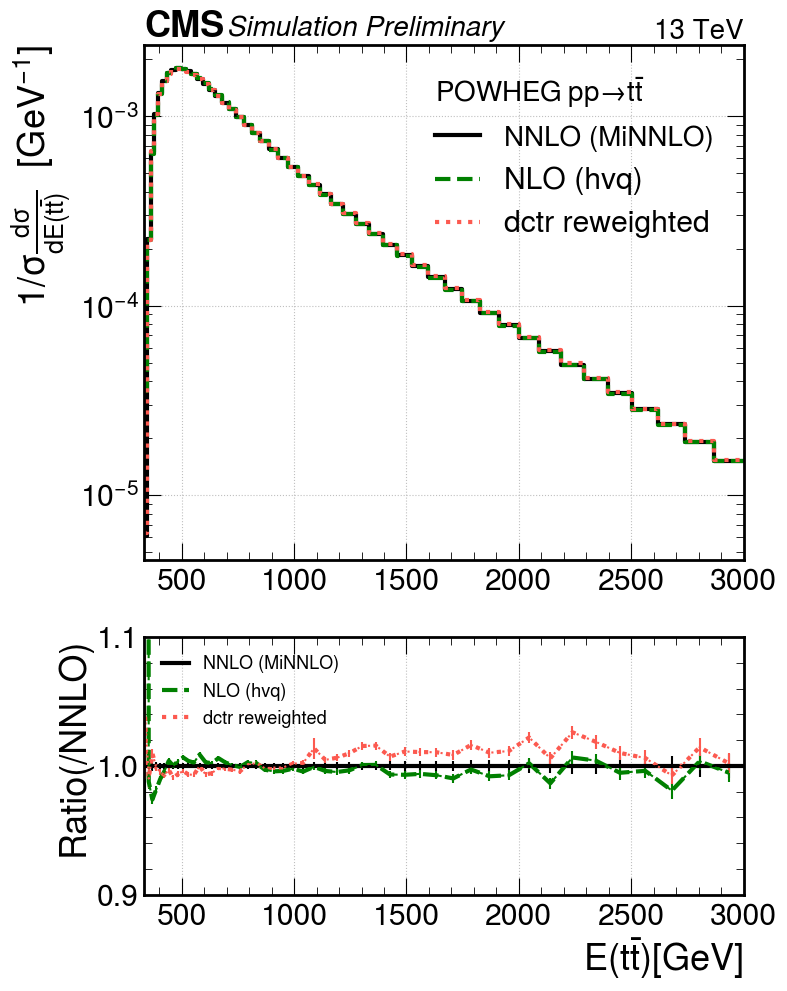

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


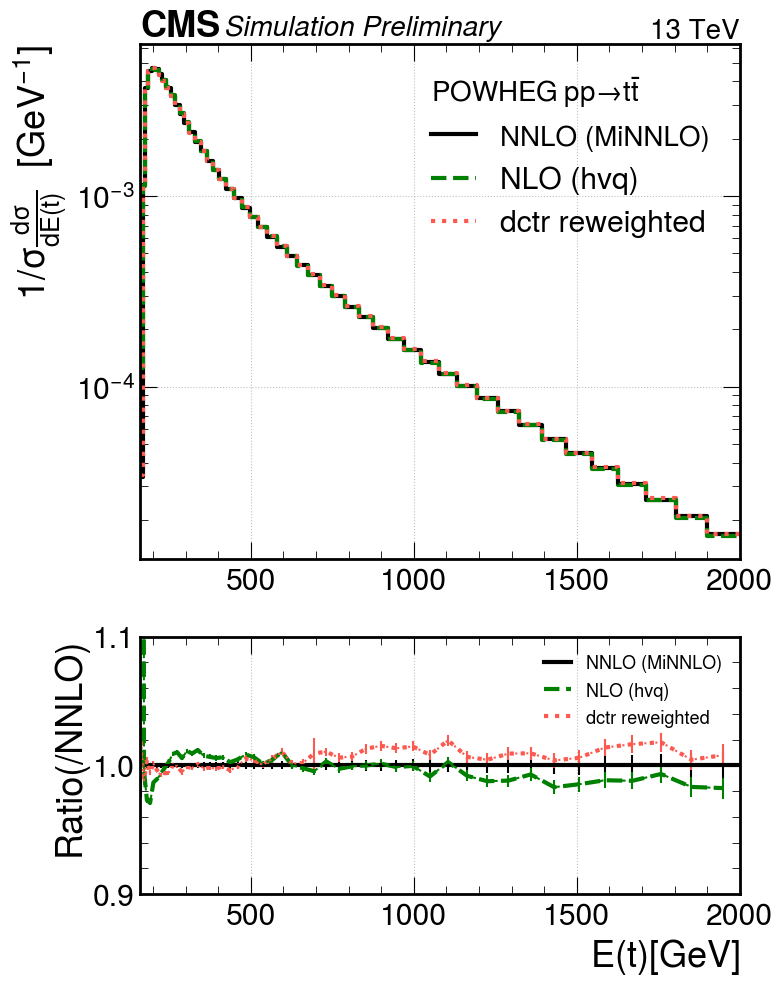

In [23]:
# E (tt) log binning
log_bins = np.logspace(np.log10(329.6132055), np.log10(3e3), 50)
DCTR.plot_ratio_cms(args, arg_index=5, part_index=0, bins=log_bins, y_scale='log') # , ratio_ylim=[0.8, 1.2])

# E (t) log binning
log_bins = np.logspace(np.log10(159.6472363), np.log10(2e3), 50)
DCTR.plot_ratio_cms(args, arg_index=5, part_index=1, bins=log_bins, y_scale='log') # , ratio_ylim=[0.8, 1.2])



'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


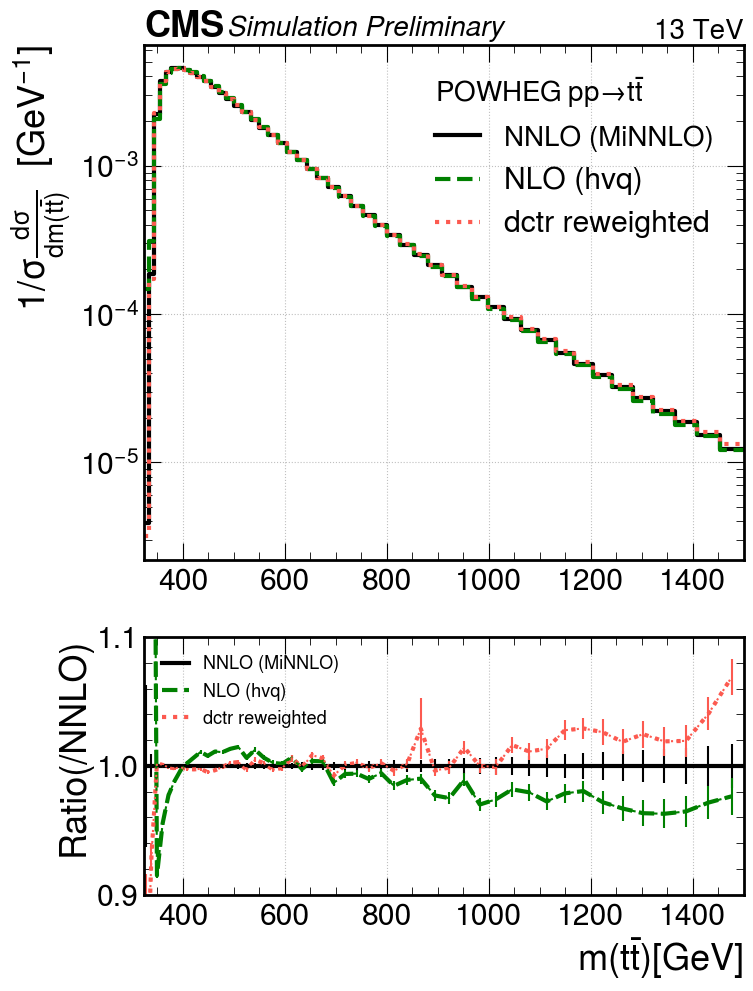

In [24]:
# m (tt) log binning
log_bins = np.logspace(np.log10(322.9727283915917), np.log10(1.5e3), 50)
DCTR.plot_ratio_cms(args, arg_index=3, part_index=0, bins=log_bins, y_scale='log') # , ratio_ylim=[0.8, 1.2])


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


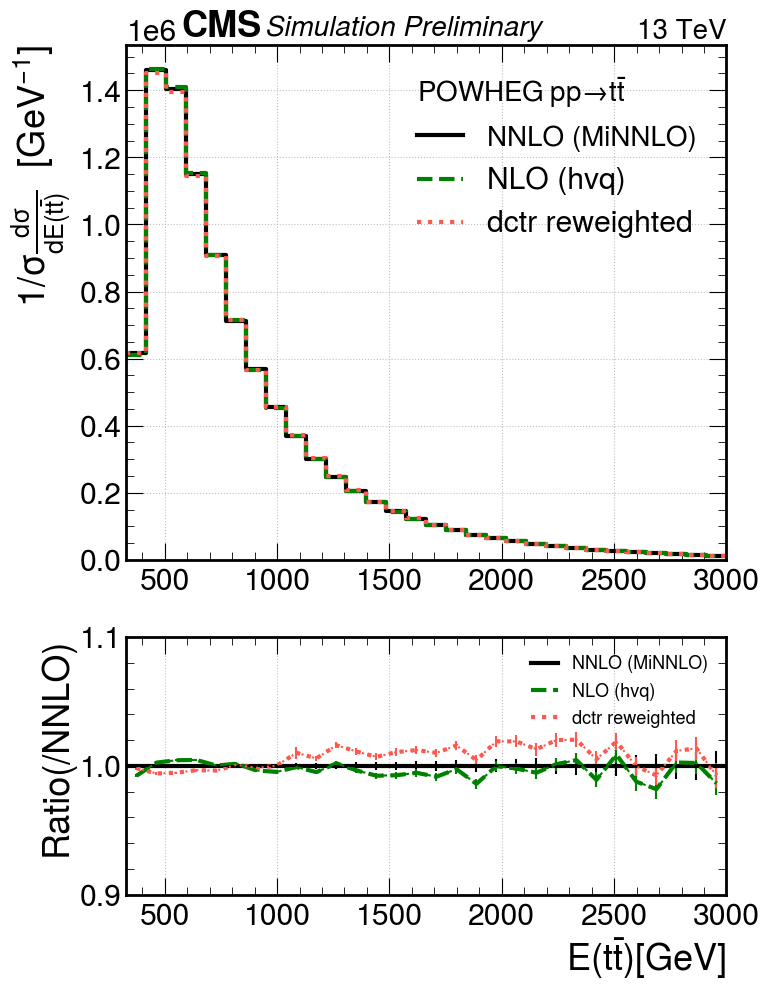

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


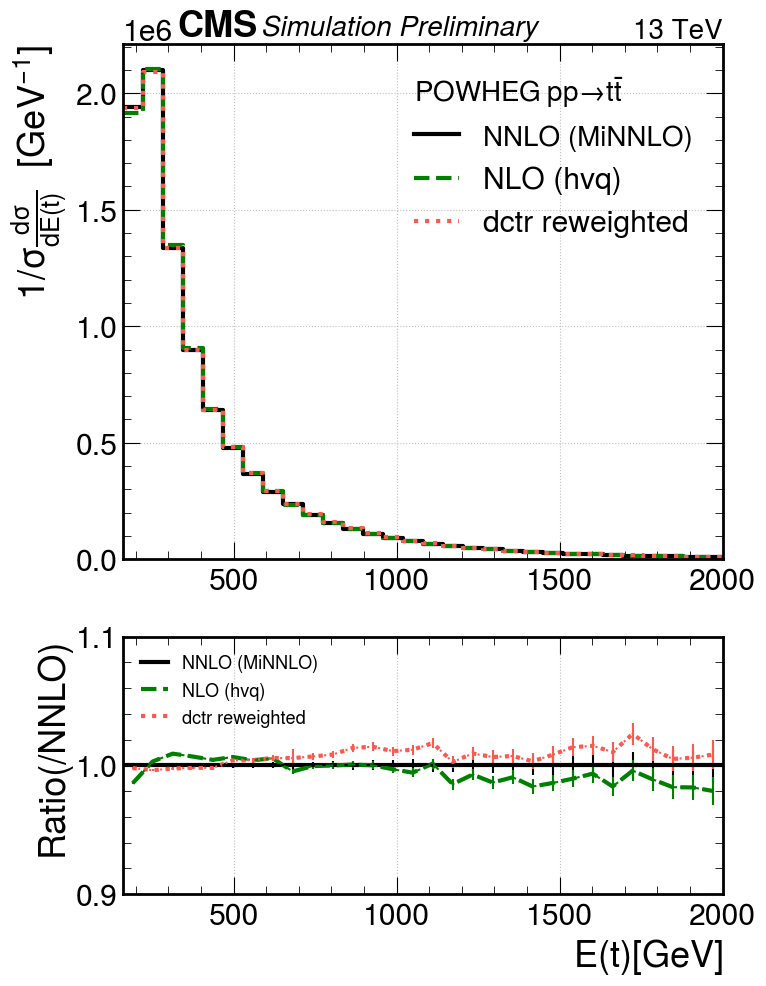

In [26]:
# E (tt) counts and lin binning and lin y_scale
DCTR.plot_ratio_cms(args, arg_index=5, part_index=0, stop=3000, div=31, density=False) # , y_scale='log') # , ratio_ylim=[0.8, 1.2])

# E (t) counts and lin binning and lin y_scale
DCTR.plot_ratio_cms(args, arg_index=5, part_index=1, stop=2000, div=31, density=False) # , y_scale='log') # , ratio_ylim=[0.8, 1.2])



'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


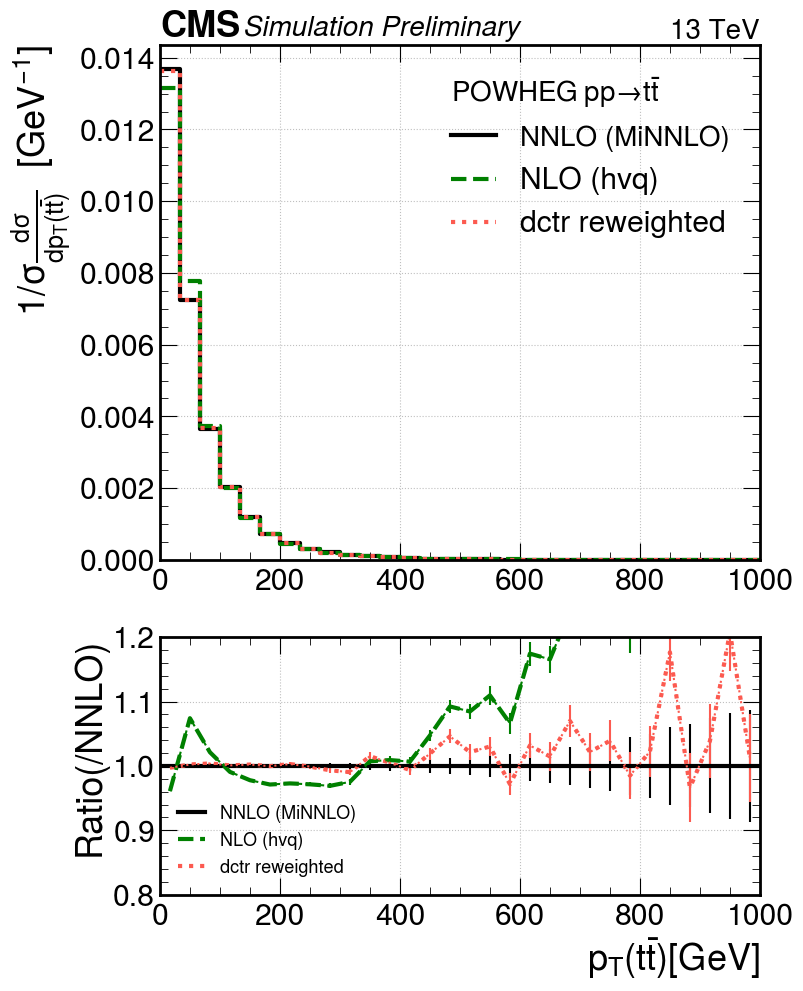

In [42]:
# p_t (tt) lin bins and lin y_scale, ratio as in bachelor thesis for comparison

DCTR.plot_ratio_cms(args, arg_index=0, part_index=0, start=0, stop=1000, div=31, density=True, ratio_ylim=[0.8, 1.2])



# bin reweighting

In [34]:
from importlib import reload
reload(DCTR)


<module 'DCTR' from '/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/DCTR.py'>

In [29]:
from hep_ml.reweight import BinsReweighter

bin_reweighter = BinsReweighter(n_bins=31, n_neighs=2) 

X0_bin_rwgt_org = []
X1_bin_rwgt_target = []


X0_bin_rwgt_org.append(X0_plt[:,0,0]) # p_T of tt-pair
X0_bin_rwgt_org.append( X0_plt[:,0,4]) # eta of tt-pair
X0_bin_rwgt_org = np.transpose(X0_bin_rwgt_org)


X1_bin_rwgt_target.append(X1_plt[:,0,0]) # p_T of tt-pair
X1_bin_rwgt_target.append(X1_plt[:,0,4]) # eta of tt-pair
X1_bin_rwgt_target = np.transpose(X1_bin_rwgt_target)

print(f'X0_bin_rwgt_org: {np.array(X0_bin_rwgt_org)}')
print(f'X1_bin_rwgt_target: {np.array(X1_bin_rwgt_target)}')



print(f'X0_bin_rwgt_org.shape: {np.shape(X0_bin_rwgt_org)}')
print(f'X0_plt_wgt length: {len(X0_plt_wgt)}')
print(f'X1_bin_rwgt_target.shape: {np.shape(X1_bin_rwgt_target)}')
print(f'X1_plt_wgt length: {len(X1_plt_wgt)}')

bin_reweighter.fit(original=X0_bin_rwgt_org, target=X1_bin_rwgt_target,
               original_weight=X0_plt_wgt, target_weight=X1_plt_wgt)


bin_rwgt = bin_reweighter.predict_weights(X0_bin_rwgt_org, original_weight=X0_plt_wgt)



X0_bin_rwgt_org: [[43.99434381  0.11367162]
 [98.50717066 -1.48717506]
 [91.13329578  1.5033101 ]
 ...
 [23.81314227 -3.03480603]
 [51.8258326  -3.55032626]
 [10.23390367  5.61318663]]
X1_bin_rwgt_target: [[ 17.69062773   5.07869867]
 [101.54794036   2.53239262]
 [  9.73909379  -3.39670274]
 ...
 [171.81870711  -2.14899785]
 [ 31.80586611   3.1694471 ]
 [ 23.63464924  -4.76648627]]
X0_bin_rwgt_org.shape: (9553938, 2)
X0_plt_wgt length: 9553938
X1_bin_rwgt_target.shape: (9553938, 2)
X1_plt_wgt length: 9553938


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


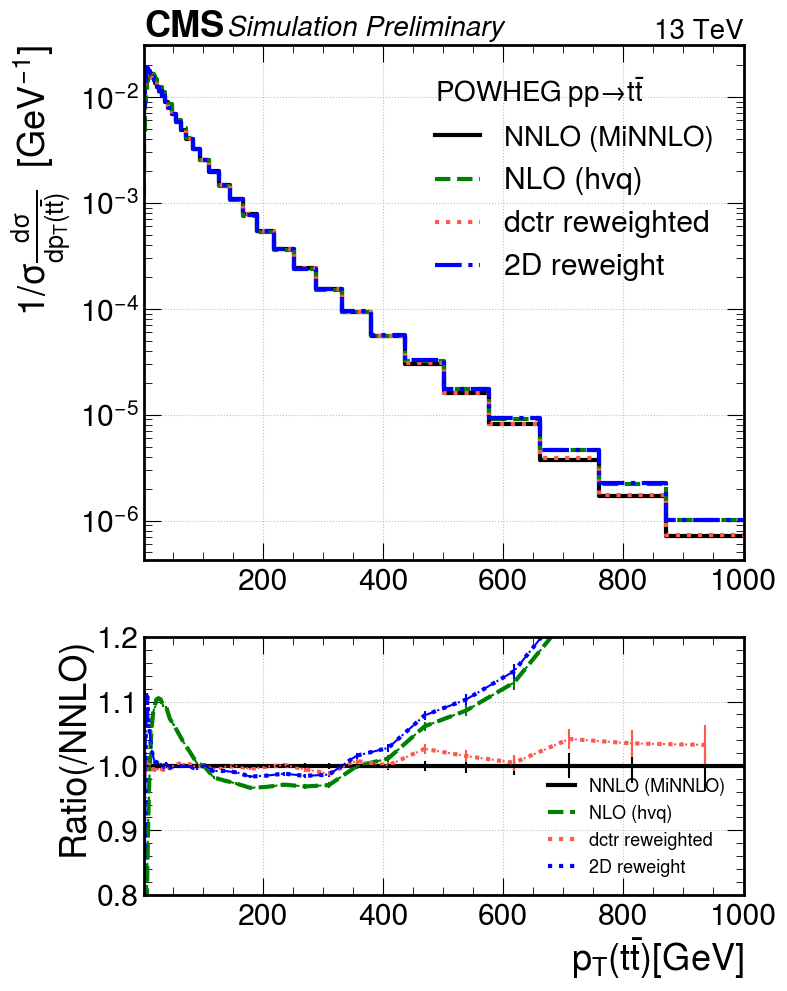

In [38]:
# p_T tt-pair dctr vs 2D bin rwgt

args_bin = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
            (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
            (X0_plt, rwgt[0], 'dctr reweighted'),
            (X0_plt, bin_rwgt, '2D reweight')]

log_bins = np.logspace(np.log10(1), np.log10(1e3), 51)

DCTR.plot_ratio_cms_4(args_bin, bins=log_bins, y_scale='log', ratio_ylim=[0.8,1.2])


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


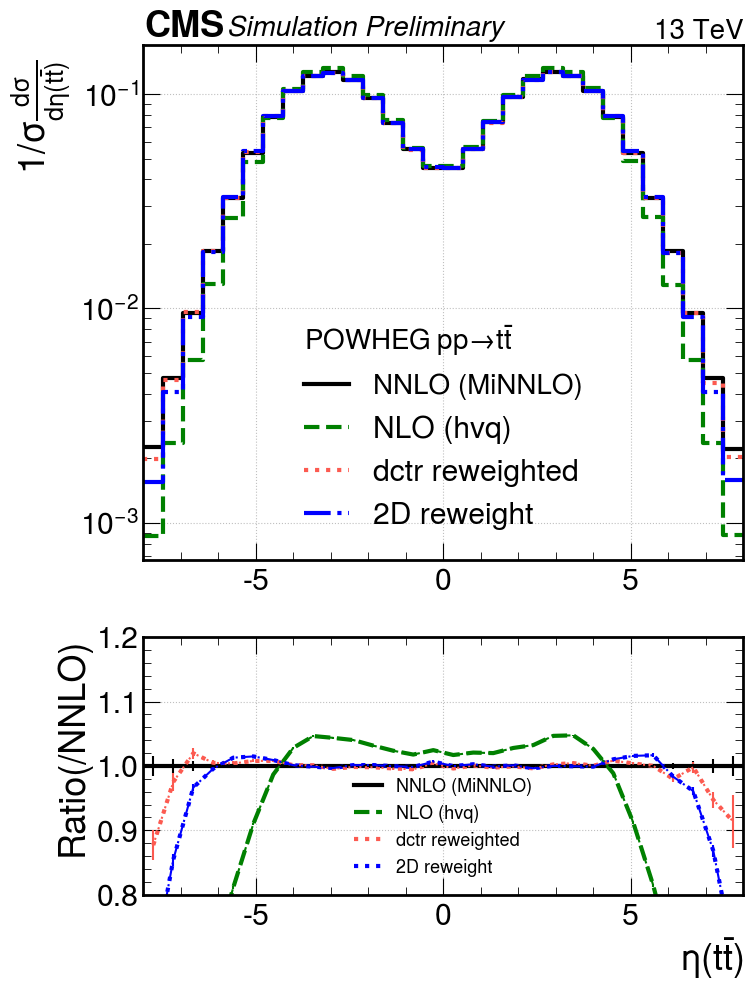

In [39]:
# eta tt-pair dctr vs 2D bin rwgt

DCTR.plot_ratio_cms_4(args_bin, arg_index=4, start = -8, stop = 8, div = 31, y_scale='log', ratio_ylim=[0.8,1.2])


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


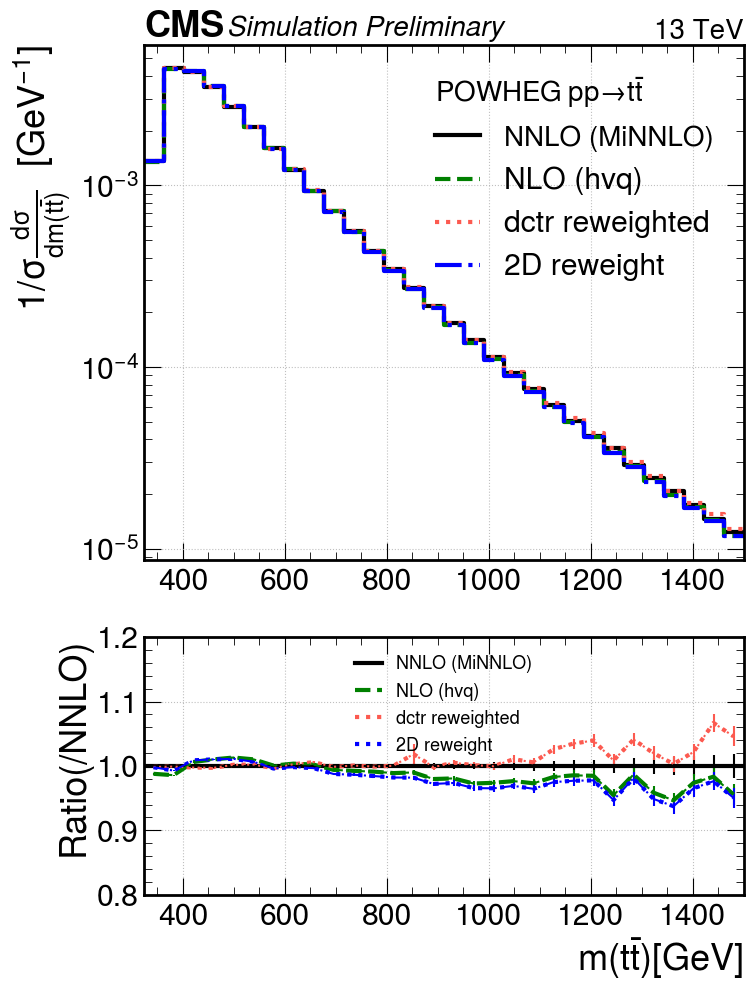

In [41]:
# p_T tt-mass dctr vs 2D bin rwgt

args_bin = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
            (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
            (X0_plt, rwgt[0], 'dctr reweighted'),
            (X0_plt, bin_rwgt, '2D reweight')]

# log_bins = np.logspace(np.log10(1), np.log10(1e3), 51)

DCTR.plot_ratio_cms_4(args_bin, arg_index=3, start = None, stop = 1500, div=31, y_scale='log', ratio_ylim=[0.8,1.2])
